<a href="https://colab.research.google.com/github/Niccolo-Rocchi/Medical_Imaging_project/blob/main/Data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic Segmentation on Pneuomothorax dataset


---


Task: Binary Mask Prediction (Pneuomothorax Area) 

Pneuomothorax Challenge: https://siim.org/page/pneumothorax_challenge

*Authors: Pirola Federico, Rocchi Niccolò*

*Università degli studi di Milano-Bicocca, Milan, Italy*

# Descriptive analisys

## Load Packages

In [1]:
%%capture
!pip install pydicom albumentations

In [2]:
from pydicom import dcmread 
import pydicom.errors 
import os 
import glob 
import numpy as np  
import matplotlib.pyplot as plt 
import pandas as pd 
from google.colab import drive
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.io import imread, imshow
from skimage.transform import resize
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from collections import Counter
from keras.layers import Concatenate as concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf
from sklearn.model_selection import train_test_split
import seaborn as sns
import albumentations as A
import cv2

## Drive

In [9]:
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/pneumotorax_data

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/DS Lab in Medicine - projects/Medical Imaging - project/pneumotorax_data


In [10]:
myDB = pd.read_pickle('./myDB.pkl') #Processed Dataframe 
myDB_ = myDB[myDB['HasFile']] #Drop links without corresponding files
myDB_m = myDB_[myDB_[' EncodedPixels'] != ' -1'] #Pneumothorax RX only

In [11]:
myDB_ 

,ImageId,EncodedPixels,Health,Age,PneumothArea,Sex,HasFile,Position,PneumArea
0,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,-1,True,51,0.0,F,True,PA,NaN
1,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,-1,True,17,0.0,F,True,AP,NaN
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,175349 7 1013 12 1009 17 1005 19 1003 20 1002...,False,69,0.0,F,True,PA,192.588682
3,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...,False,57,0.0,F,True,AP,52.383744
4,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1...,False,57,0.0,F,True,AP,216.873216
...,...,...,...,...,...,...,...,...,...
11577,1.2.276.0.7230010.3.1.4.8323329.4461.151787518...,592067 6 1016 10 1012 14 1007 18 1004 20 1003...,False,22,0.0,F,True,PA,24.395657
11578,1.2.276.0.7230010.3.1.4.8323329.4461.151787518...,610576 3 1001 38 981 53 966 63 956 73 947 87 ...,False,22,0.0,F,True,PA,293.156864
11579,1.2.276.0.7230010.3.1.4.8323329.32730.15178751...,-1,True,43,0.0,F,True,PA,NaN
11580,1.2.276.0.7230010.3.1.4.8323329.13252.15178752...,-1,True,45,0.0,M,True,PA,NaN


## Esplorative

In [12]:
for filename in os.listdir('./dicom_files'):
    f = os.path.join('./dicom_files', filename)
    # checking if it is a file
    if not os.path.isfile(f):
        print(f)

In [13]:
#AP RX example
dcmHead = dcmread('./dicom_files/1.2.276.0.7230010.3.1.4.8323329.1664.1517875168.814209.dcm')

In [14]:
#PA RX example
dcmHead_2 = dcmread('./dicom_files/1.2.276.0.7230010.3.1.4.8323329.12004.1517875236.852955.dcm')

In [15]:
print(dcmHead)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.1664.1517875168.814209
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.1664.1517875168.814209
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

In [16]:
print(dcmHead_2)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.12004.1517875236.852955
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.12004.1517875236.852955
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [17]:
img_prova = dcmHead.pixel_array

(-0.5, 1023.5, 1023.5, -0.5)

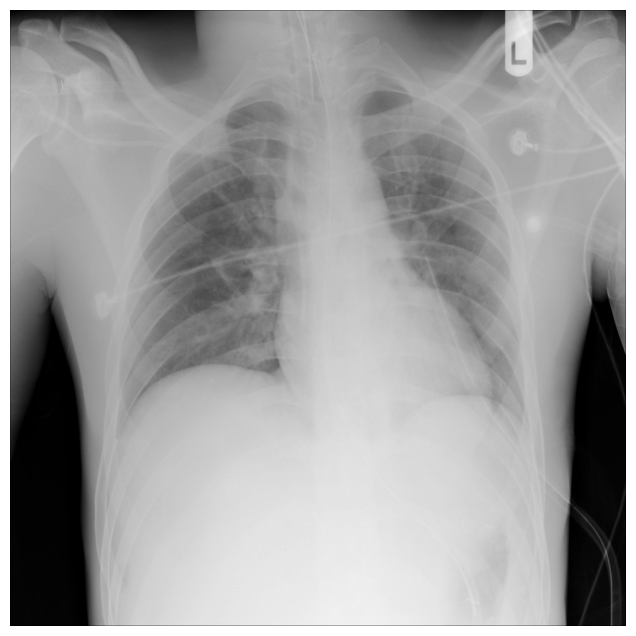

In [18]:
plt.figure(figsize=(8,8))
plt.imshow(img_prova[:,:],cmap='gray',vmin=10,vmax=240)
plt.axis('off')

In [19]:
img_prova_2 = dcmHead_2.pixel_array

(-0.5, 1023.5, 1023.5, -0.5)

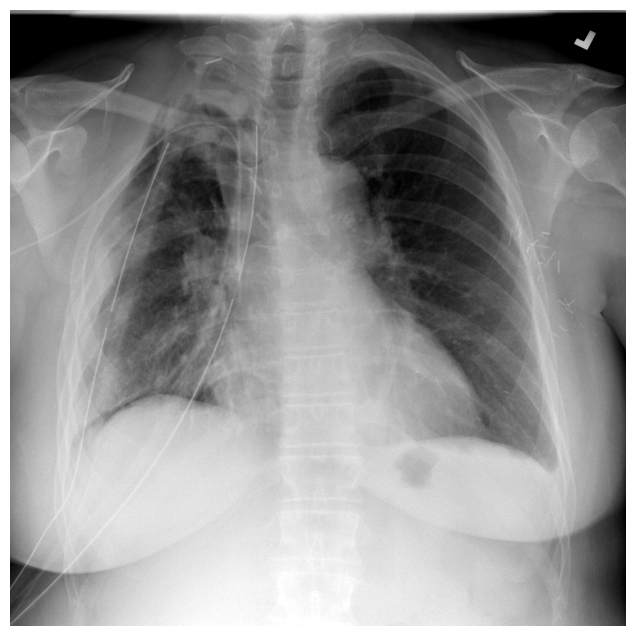

In [20]:
plt.figure(figsize=(8,8))
plt.imshow(img_prova_2[:,:],cmap='gray',vmin=10,vmax=240)
plt.axis('off')

In [21]:
def rle2mask(rle, width, height):
    """
    RLE to mask conversion provided by competetion organizers with the dataset.
    """
    mask= np.zeros(width*height)

    if rle != ' -1':
      array = np.asarray([int(x) for x in rle.split()])
      starts = array[0::2]
      lengths = array[1::2]

      current_position = 0
      for index, start in enumerate(starts):
          current_position += start
          mask[current_position:current_position+lengths[index]] = 255
          current_position += lengths[index]

    return mask.reshape(width, height, order='F')

In [22]:
dcmHead_3 = dcmread('./dicom_files/1.2.276.0.7230010.3.1.4.8323329.12004.1517875236.852955.dcm') #confronto con immagine ridotta
img_3 = dcmHead_3.pixel_array
mask = rle2mask(myDB_.loc[1112][' EncodedPixels'], 1024, 1024)

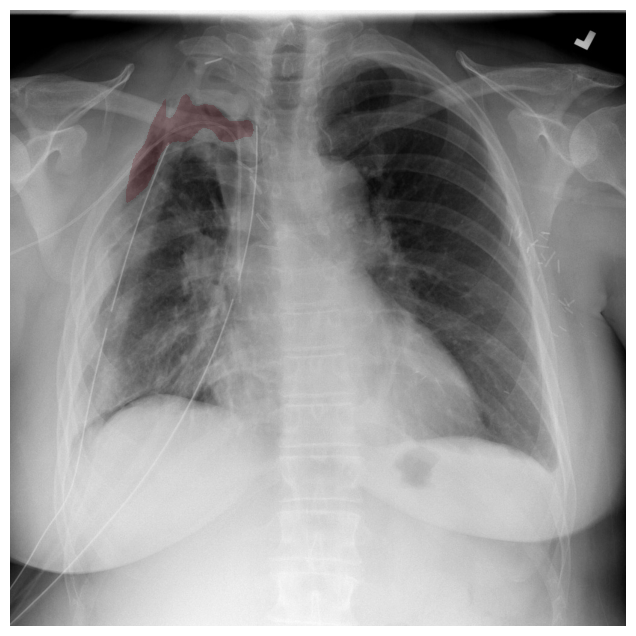

In [23]:
plt.figure(figsize=(8,8))
plt.imshow(img_3[:,:],cmap='gray')
plt.axis('off')
mask2 = mask.copy()
mask2[mask2<0.5]=np.nan
plt.imshow(0.1*mask2,alpha=0.2,cmap='Reds',vmin=0,vmax=1)

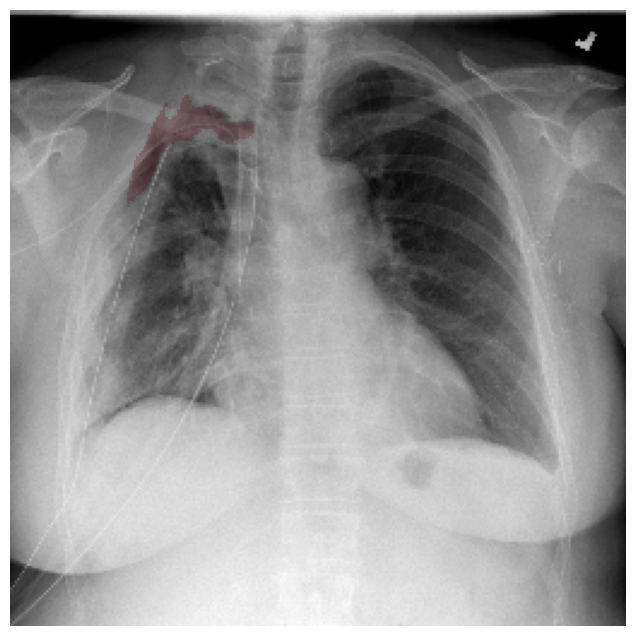

In [24]:
plt.figure(figsize=(8,8))
plt.imshow(img_3[::4, ::4],cmap='gray')
plt.axis('off')
mask2 = mask[::4, ::4].copy()
mask2[mask2<0.5]=np.nan
plt.imshow(0.1*mask2,alpha=0.2,cmap='Reds',vmin=0,vmax=1)

In [25]:
dicomList = glob.glob('./dicom_files/*.dcm')

In [26]:
nAnalisi = len(dicomList)
immDimV = np.zeros((2,nAnalisi))
pixSpV = np.zeros((2,nAnalisi))
sexV = np.zeros((1,nAnalisi))
ageV = np.zeros((1,nAnalisi))
orientationV = [] #np.chararray((1,nAnalisi))

In [27]:
fName = './dicom_files/1.2.276.0.7230010.3.1.4.8323329.4869.1517875185.177643.dcm'
dcmFL = dcmread(fName)

In [28]:
dcmFL.ViewPosition

'PA'

In [29]:
for idx,fName  in enumerate(dicomList[:nAnalisi]):
    dcmFL = dcmread(fName)
    immDimV[0,idx] = dcmFL.Rows
    immDimV[1,idx] = dcmFL.Columns
    pixSpV[:,idx] = dcmFL.PixelSpacing
    orientationV.append(dcmFL.ViewPosition)
    if dcmFL.PatientSex == 'F':
        sexV[0,idx]=1
    elif dcmFL.PatientSex == 'M':
        sexV[0,idx]=0
    else:
        sexV[0,idx]=-1
    ageV[0,idx] = int(dcmFL.PatientAge)
    if int(dcmFL.PatientAge) > 100:
      print(dcmFL.PatientAge)

148
413


In [30]:
np.unique(immDimV)

array([1024.])

In [31]:
# Range of Patients Age -> 2 Patient with Age > 100 years 
print(min(ageV[0]),max(ageV[0]))

1.0 413.0


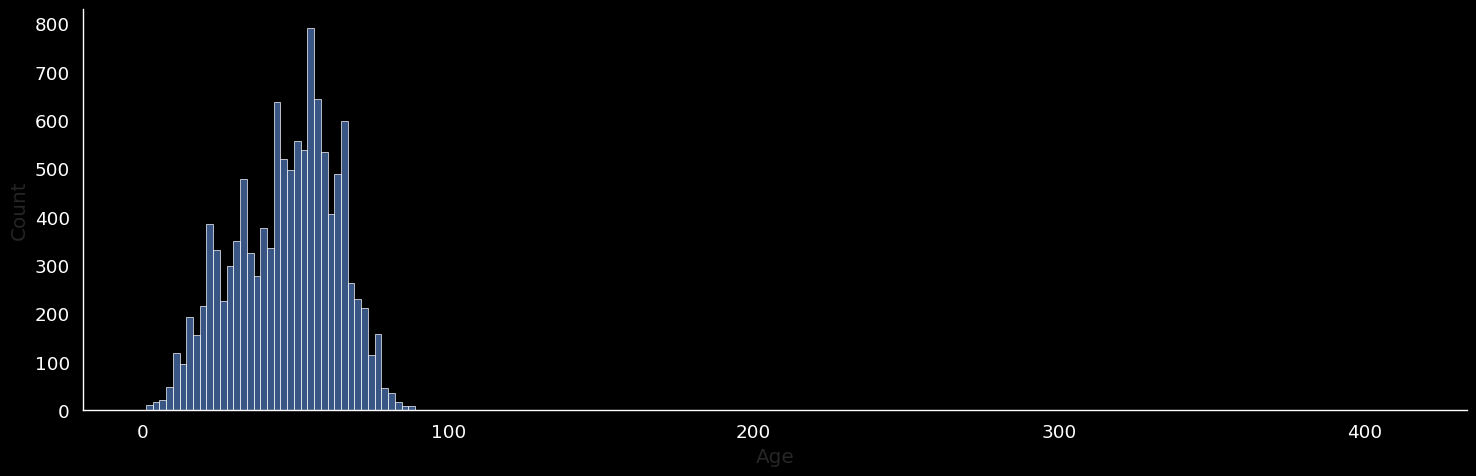

In [32]:
# Plot of Age distribution
sns.set(font_scale = 1.2, rc={'figure.figsize':(5,5),'axes.facecolor':'black', 'figure.facecolor':'black','axes.linewidth': 1,'ytick.color': 'white','xtick.color': 'white','axes.edgecolor': 'white','axes.grid': False, 'text.color': 'white', 'axes.spines.right': False, 'axes.spines.top': False, 'patch.linewidth': 0.7})
sns.displot(myDB_, x="Age", aspect=3)

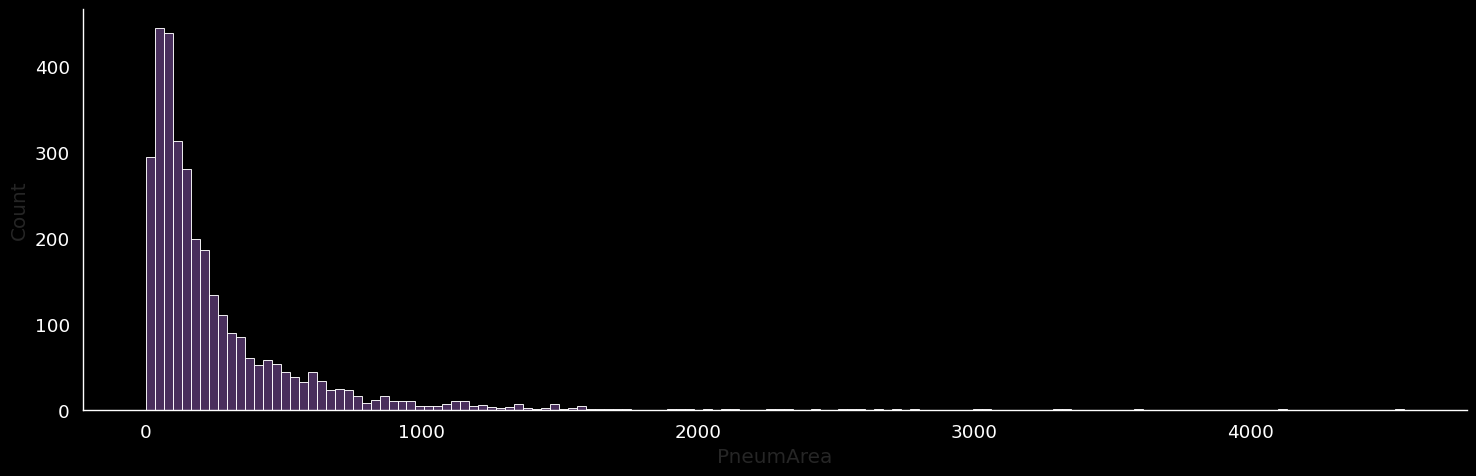

In [33]:
# Plot of Pneumothorax Area distribution
sns.set(font_scale = 1.2, rc={'figure.figsize':(5,5),'axes.facecolor':'black', 'figure.facecolor':'black','axes.linewidth': 1,'ytick.color': 'white','xtick.color': 'white','axes.edgecolor': 'white','axes.grid': False, 'text.color': 'white', 'axes.spines.right': False, 'axes.spines.top': False, 'patch.linewidth': 0.7})
sns.displot(myDB_m, x="PneumArea", aspect=3,color='#63407C')

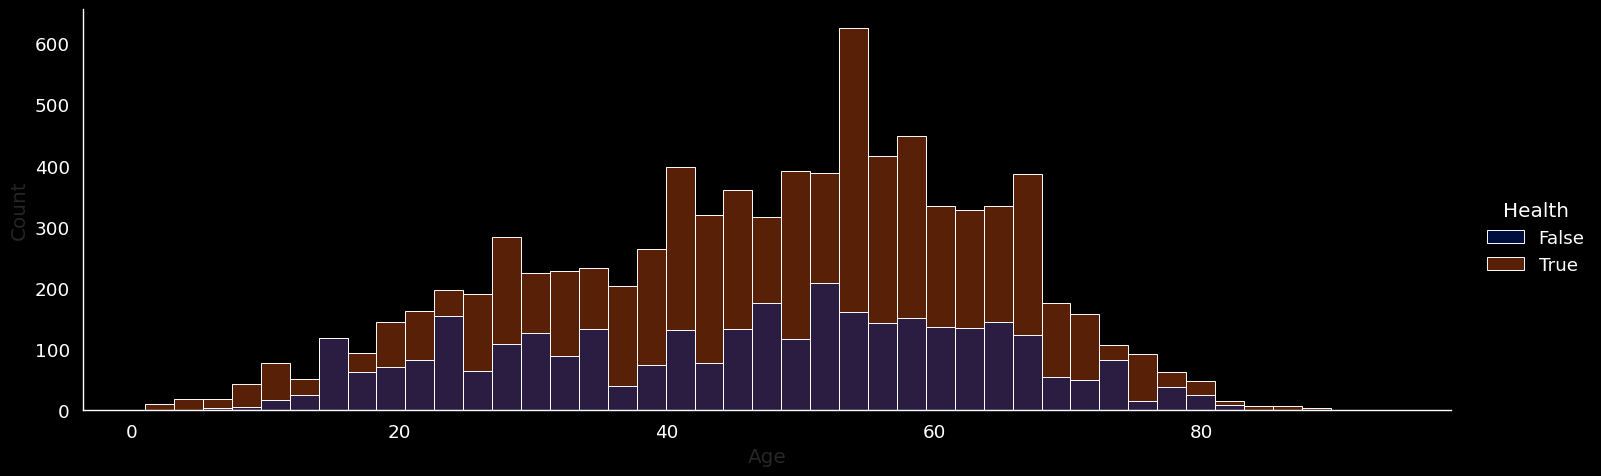

In [34]:
# Plot of Age distribution stratified by patient health condition
sns.displot(myDB_[myDB_['Age'] < 100].sort_values('Health',ascending=False), x="Age", hue="Health", aspect=3,palette='dark')

<Axes: title={'center': 'Chest Posterior Anterior (PA) and Anterior Posterior (AP)'}>

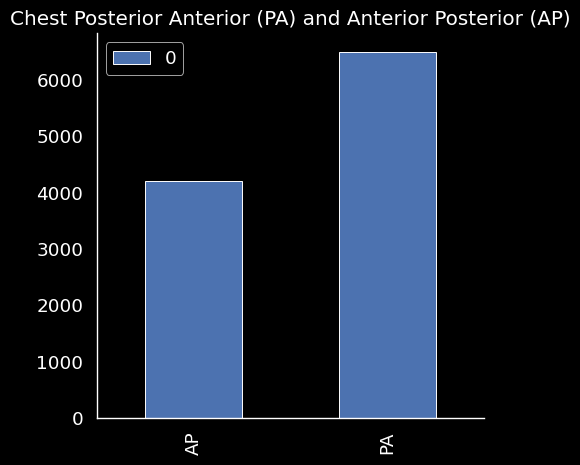

In [35]:
# Chest Posterior Anterior (PA) and Anterior Posterior (AP) radiographs
letter_counts = Counter(orientationV)
df = pd.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar',title='Chest Posterior Anterior (PA) and Anterior Posterior (AP)')

In [36]:
print('Pneumothorax women: ',len(myDB_[myDB_['Health'] == False][myDB_['Sex'] == 'F']),'Pneumothorax men: ',len(myDB_[myDB_['Health'] == False][myDB_['Sex'] == 'M']))

Pneumothorax women:  1416 Pneumothorax men:  1866


<ipython-input-36-0d703edada5f>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print('Pneumothorax women: ',len(myDB_[myDB_['Health'] == False][myDB_['Sex'] == 'F']),'Pneumothorax men: ',len(myDB_[myDB_['Health'] == False][myDB_['Sex'] == 'M']))


In [37]:
print('Healthy women: ',len(myDB_[myDB_['Health']][myDB_['Sex'] == 'F']),'Healthy Men: ',len(myDB_[myDB_['Health']][myDB_['Sex'] == 'M']))

Healthy women:  3740 Healthy Men:  4545


<ipython-input-37-9491460f059b>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print('Healthy women: ',len(myDB_[myDB_['Health']][myDB_['Sex'] == 'F']),'Healthy Men: ',len(myDB_[myDB_['Health']][myDB_['Sex'] == 'M']))


## Image Augmentation Examples

In [38]:
dcmHead_4 = dcmread('./dicom_files/1.2.276.0.7230010.3.1.4.8323329.32287.1517875159.439426.dcm') #confronto con immagine ridotta
img_4 = dcmHead_4.pixel_array
mask_4 = rle2mask(myDB_.iloc[611][' EncodedPixels'], 1024, 1024)

In [39]:
# Random Crop From Borders
transform_cropborders = A.Compose([A.RandomResizedCrop(1024,1024,scale = (1,1), ratio=(0.8, 1.25),p=1)])
transformed_image_cropborders = transform_cropborders(image=img_4)["image"]
transformed_mask_cropborders = transform_cropborders(image=mask_4)["image"]

In [40]:
# Brightness and Contraxt Transformation
transform_brightnesscontraxt = A.Compose([A.RandomBrightnessContrast(p=1,brightness_limit=0.4,contrast_limit=0.4)])
transformed_image_brightnesscontraxt = transform_brightnesscontraxt(image=img_4)["image"]
transformed_mask_brightnesscontraxt = mask_4 #binary mask does not change because the dimension are not transformed

In [41]:
# Shift and Rotate
transform_shiftscalerotate = A.Compose([A.ShiftScaleRotate(p=1,scale_limit=0.1,rotate_limit=30,shift_limit=0.1,border_mode=cv2.BORDER_CONSTANT)])
transformed_shiftscalerotate = transform_shiftscalerotate(image=img_4,mask=mask_4)
transformed_image_shiftscalerotate = transformed_shiftscalerotate['image']
transformed_mask_shiftscalerotate = transformed_shiftscalerotate['mask']

In [42]:
# Grid Distortion
transform_griddistortion = A.Compose([A.GridDistortion(p=1,distort_limit=0.5)])
transformed_griddistortion = transform_griddistortion(image=img_4,mask=mask_4)
transformed_image_griddistortion = transformed_griddistortion['image']
transformed_mask_griddistortion = transformed_griddistortion['mask']

In [43]:
# Elastic Transformation
transform_elastic = A.Compose([A.ElasticTransform(p=1,border_mode=cv2.BORDER_CONSTANT)])
transformed_elastic = transform_elastic(image=img_4,mask=mask_4)
transformed_image_elastic = transformed_elastic['image']
transformed_mask_elastic = transformed_elastic['mask']

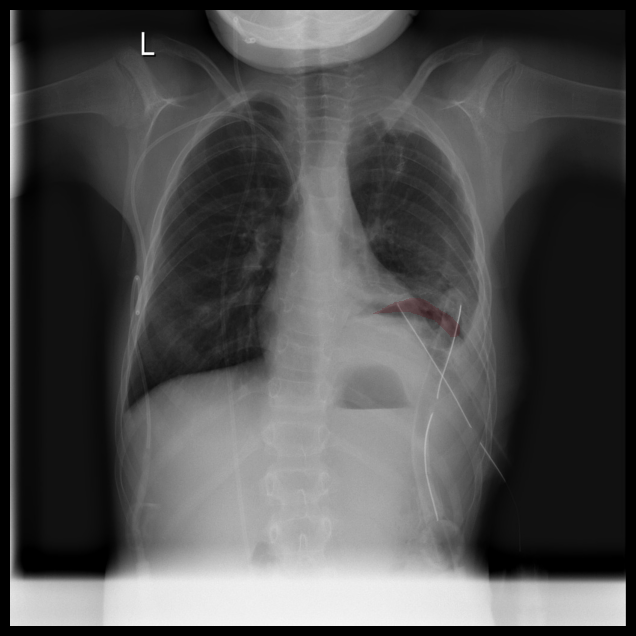

In [44]:
plt.figure(figsize=(8,8))
plt.imshow(img_4[:,:],cmap='gray')
plt.axis('off')
mask_ = mask_4.copy()
mask_[mask_<0.5]=np.nan
plt.imshow(0.1*mask_,alpha=0.2,cmap='Reds',vmin=0,vmax=1)

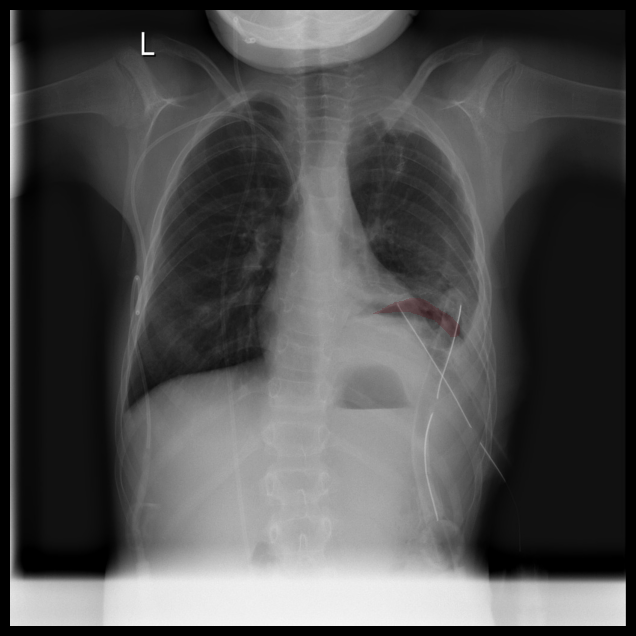

In [45]:
plt.figure(figsize=(8,8))
plt.imshow(transformed_image_cropborders[:,:],cmap='gray')
plt.axis('off')
transformed_mask_cropborders_ = transformed_mask_cropborders.copy()
transformed_mask_cropborders_[transformed_mask_cropborders_<0.5]=np.nan
plt.imshow(0.1*transformed_mask_cropborders_,alpha=0.2,cmap='Reds',vmin=0,vmax=1)

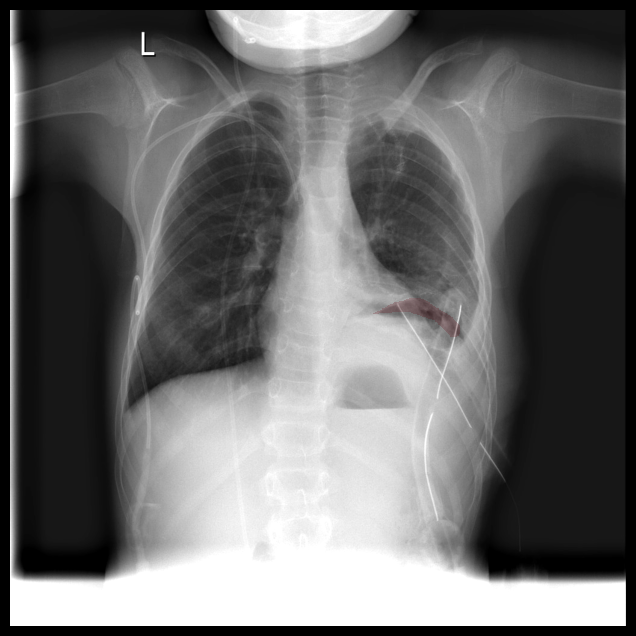

In [46]:
plt.figure(figsize=(8,8))
plt.imshow(transformed_image_brightnesscontraxt[:,:],cmap='gray')
plt.axis('off')
transformed_mask_brightnesscontraxt_ = transformed_mask_brightnesscontraxt.copy()
transformed_mask_brightnesscontraxt_[transformed_mask_brightnesscontraxt_<0.5]=np.nan
plt.imshow(0.1*transformed_mask_brightnesscontraxt_,alpha=0.2,cmap='Reds',vmin=0,vmax=1)

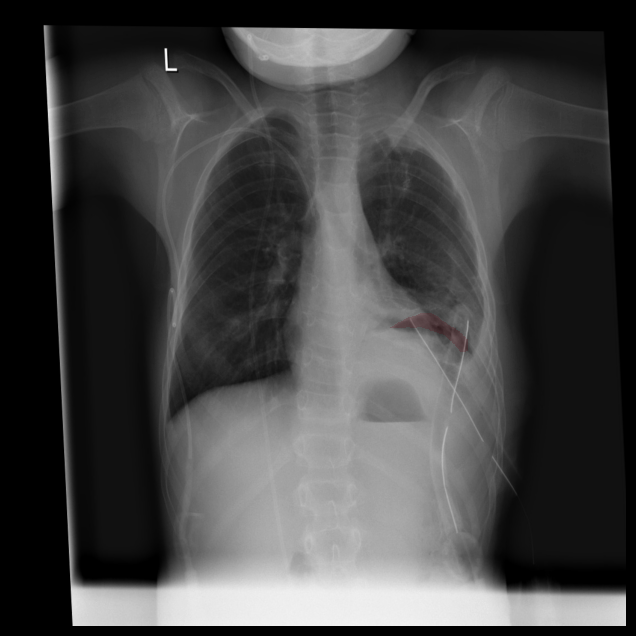

In [47]:
plt.figure(figsize=(8,8))
plt.imshow(transformed_image_elastic[:,:],cmap='gray')
plt.axis('off')
transformed_mask_elastic_ = transformed_mask_elastic.copy()
transformed_mask_elastic_[transformed_mask_elastic_<0.5]=np.nan
plt.imshow(0.1*transformed_mask_elastic_,alpha=0.2,cmap='Reds',vmin=0,vmax=1)

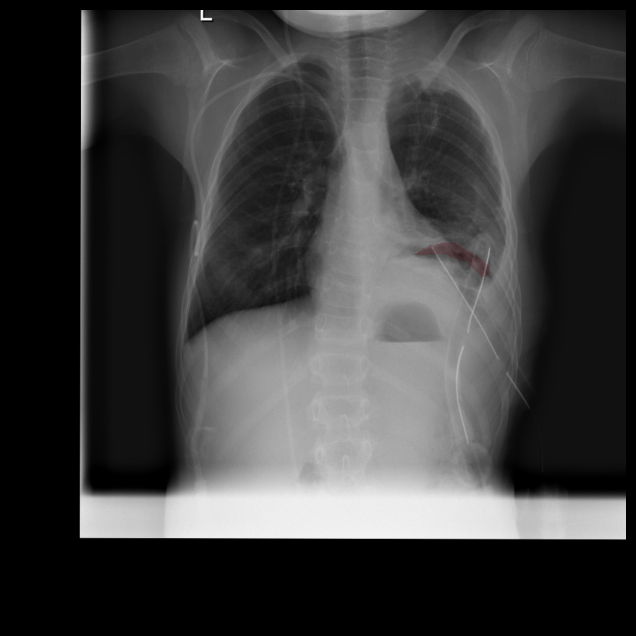

In [48]:
plt.figure(figsize=(8,8))
plt.imshow(transformed_image_shiftscalerotate[:,:],cmap='gray')
plt.axis('off')
transformed_mask_shiftscalerotate_ = transformed_mask_shiftscalerotate.copy()
transformed_mask_shiftscalerotate_[transformed_mask_shiftscalerotate_<0.5]=np.nan
plt.imshow(0.1*transformed_mask_shiftscalerotate_,alpha=0.2,cmap='Reds',vmin=0,vmax=1)

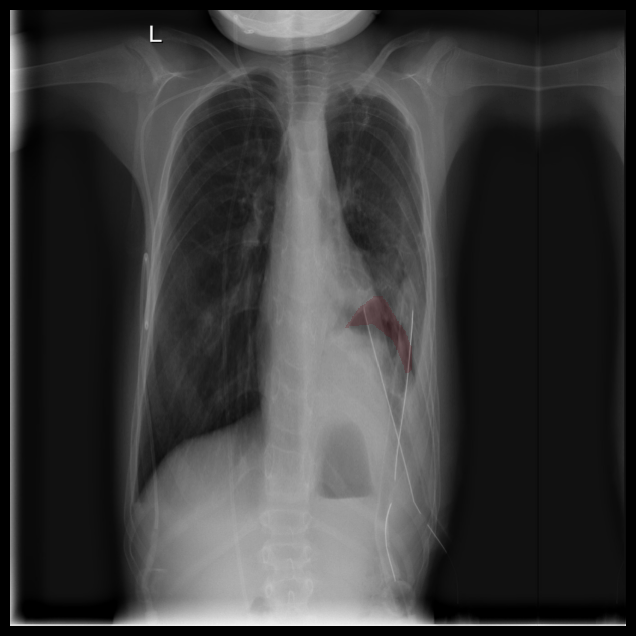

In [49]:
plt.figure(figsize=(8,8))
plt.imshow(transformed_image_griddistortion[:,:],cmap='gray')
plt.axis('off')
transformed_mask_griddistortion_ = transformed_mask_griddistortion.copy()
transformed_mask_griddistortion_[transformed_mask_griddistortion_<0.5]=np.nan
plt.imshow(0.1*transformed_mask_griddistortion_,alpha=0.2,cmap='Reds',vmin=0,vmax=1)